In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
# from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, LeakyReLU, Dropout, BatchNormalization, MaxPooling2D, Lambda
from keras.models import Model
from sklearn.metrics import mean_squared_error as mse
from progressbar import ProgressBar
from image_process import ImageProcess
import const, cv2
from drive_data import DriveData
from config import Config

import matplotlib.pyplot as plt
import sys
sys.setrecursionlimit(10**7)
tf.compat.v1.experimental.output_all_intermediates(True)
tf.compat.v1.disable_eager_execution()

               Configuration Settings
Neural Net:     	fusion_kdh_jaerock3
Data Collection:	fusion_kdh_jaerock3
Run Neural:     	fusion_kdh_jaerock3




In [2]:
config = Config.neural_net
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
gpu_config = tf.compat.v1.ConfigProto()
gpu_config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=gpu_config)
tf.compat.v1.keras.backend.set_session(sess)

In [20]:
"""
## Encoder
"""

"""
## Create a sampling layer
"""
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs_img = tf.keras.Input(batch_shape=(1, 1, 160, 160, 3))
encoder_inputs_str = tf.keras.Input(batch_shape=(1, 1, 1))
encoder_inputs_vel = tf.keras.Input(batch_shape=(1, 1, 1))
encoder_inputs_time = tf.keras.Input(batch_shape=(1, 1, 1))
x = layers.TimeDistributed(layers.Conv2D(24, (5, 5), padding='same', name='conv2d_1'))(encoder_inputs_img)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('elu'))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), name='pool2d_1'))(x)
# x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), name='pool2d_1'))(x)
x = layers.TimeDistributed(layers.Conv2D(36, (5, 5), padding='same', name='conv2d_2'))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('elu'))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), name='pool2d_2'))(x)
x = layers.TimeDistributed(layers.Conv2D(48, (5, 5), padding='same', name='conv2d_3'))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('elu'))(x)
x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', name='conv2d_4'))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('elu'))(x)
x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', name='conv2d_5'))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('elu'))(x)
latent = layers.TimeDistributed(layers.Flatten())(x)
latent = layers.TimeDistributed(layers.Dense(500))(latent)
latent = layers.TimeDistributed(layers.LayerNormalization())(latent)
latent = layers.TimeDistributed(layers.Activation('tanh'))(latent)
fc_s1  = layers.TimeDistributed(layers.Dense(100))(encoder_inputs_str)
fc_s1  = layers.TimeDistributed(layers.Activation('elu'))(fc_s1)
fc_s2  = layers.TimeDistributed(layers.Dense(50))(fc_s1)
fc_s2  = layers.TimeDistributed(layers.Activation('elu'))(fc_s2)
fc_v1  = layers.TimeDistributed(layers.Dense(100))(encoder_inputs_vel)
fc_v1  = layers.TimeDistributed(layers.Activation('elu'))(fc_v1)
fc_v2  = layers.TimeDistributed(layers.Dense(50))(fc_v1)
fc_v2  = layers.TimeDistributed(layers.Activation('elu'))(fc_v2)
fc_t1  = layers.TimeDistributed(layers.Dense(100))(encoder_inputs_time)
fc_t1  = layers.TimeDistributed(layers.Activation('elu'))(fc_t1)
fc_t2  = layers.TimeDistributed(layers.Dense(50))(fc_t1)
fc_t2  = layers.TimeDistributed(layers.Activation('elu'))(fc_t2)
conc_1 = layers.concatenate([latent, fc_s2, fc_v2, fc_t2])
bilstm = layers.Bidirectional(layers.LSTM(500, input_shape=(1000, 1), batch_size=1, stateful=True))(conc_1)
fc_1   = layers.Dense(500)(bilstm)
fc_1   = layers.Activation('elu')(fc_1)
fc_2   = layers.Dense(100)(fc_1)
x   = layers.Activation('elu')(fc_2)
z_mean = layers.Dense(50, name="z_mean")(x)
z_log_var = layers.Dense(50, name="z_log_var")(x)
encoder_output = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model([ encoder_inputs_img, encoder_inputs_str,
                        encoder_inputs_vel, encoder_inputs_time], 
                        [z_mean, z_log_var, encoder_output], 
                        name="encoder")

"""
## Decoder
"""
latent_inputs = tf.keras.Input(shape=(50,))
x = layers.Dense(40 * 40 * 64, activation="elu")(latent_inputs)
x = layers.Reshape((40, 40, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="elu",  padding="same")(x)
x = layers.Conv2DTranspose(36, 3, activation="elu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(24, 3, activation="elu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

"""
## VAE
"""
model_input = [ encoder_inputs_img, encoder_inputs_str,
                        encoder_inputs_vel, encoder_inputs_time]
model_output = decoder(encoder_output)

VarAE=Model(model_input, model_output)
VarAE.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(1, 1, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
time_distributed_33 (TimeDistri (1, 1, 160, 160, 24) 1824        input_6[0][0]                    
__________________________________________________________________________________________________
time_distributed_34 (TimeDistri (1, 1, 160, 160, 24) 96          time_distributed_33[0][0]        
__________________________________________________________________________________________________
time_distributed_35 (TimeDistri (1, 1, 160, 160, 24) 0           time_distributed_34[0][0]        
____________________________________________________________________________________________

In [29]:
pretrained_path = '/home2/kdh/vae/oscar/vae_z/vae_kdh_ckpt.2693-1991.201.h5'
base_weightsfile = pretrained_path+'.h5'
base_modelfile   = pretrained_path+'.json'

# VarAE.run_eagerly = True
VarAE.load_weights(pretrained_path)


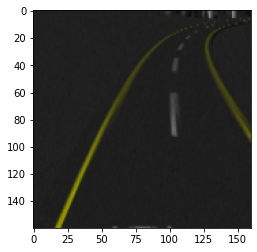

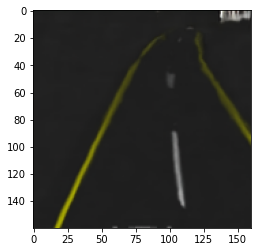

In [30]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img
def plot_latent_space(trained_decoder, pimage, n=50, figsize=15):


    image = pimage[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
    image = cv2.resize(image, 
                        (config['input_image_width'],
                        config['input_image_height']))
    image = np.array(image).astype("float32")/255.0
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    image = np.expand_dims(image, axis=(0,1))
    # image = np.expand_dims(image, axis=0)
    # vel = np.array()


    X_tvel = np.array([[[14.5]]])
    # print(X_tvel.shape)
    X_tstr = np.array([[[0.0]]])
    X_ttime = np.array([[[0.3]]])
    # print(X_tvel.shape)
    X_train = [image, X_tstr, X_tvel, X_ttime]

    # x_encoded = VarAE.predict(X_train)*255.0
    # x_encoded = VarAE_z2.predict(X_train)*255.0
    x_encoded = VarAE.predict(X_train)*255.0
    # print(x_encoded)
    x_encoded_out = np.squeeze(x_encoded,axis=0)
    # pred_image = np.zeros([160,160,3], np.uint8)
    pred_image = array_to_img(x_encoded_out)
    pred_image = np.array(pred_image)
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
    # pred_img = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
    # print(type(pred_img))
    # print(pred_image.shape)
    plt.imshow(pred_image)
    # plt.imshow(cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB))
    plt.show()

    # origin_image_name = '/home2/kdh/vae/vae_test/2022-12-08-14-30-12-332957.jpg'
    # cv2.imwrite('/')
    # plt.xticks(pixel_range, sample_range_x)
    # plt.yticks(pixel_range, sample_range_y)
    # plt.xlabel("z[0]")
    # plt.ylabel("z[1]")

test_img = cv2.imread('/home2/kdh/vae/2022-12-08-14-25-28/2022-12-08-14-30-12-332957.jpg')
plot_latent_space(decoder, test_img)

In [5]:
from sklearn.model_selection import train_test_split
"""
## Dataset
"""
image_process = ImageProcess()
config = Config.neural_net
# data_path = "/mnt/exData/internal_simulation/test/2022-03-08-17-18-14/"
data_path = "/home2/kdh/vae/2022-12-08-14-25-28"
if data_path[-1] == '/':
    data_path = data_path[:-1]

    loc_slash = data_path.rfind('/')
    if loc_slash != -1: # there is '/' in the data path
        model_name = data_path[loc_slash + 1:] # get folder name
        #model_name = model_name.strip('/')
    else:
        model_name = data_path
csv_path = data_path + '/' + model_name + const.DATA_EXT
csv_path = "/home2/kdh/vae/2022-12-08-14-25-28/2022-12-08-14-25-00.csv"
# data = DriveData(csv_path)
print(csv_path)
# data_path = data_path
# data.read()

csv_header = ['image_fname', 
                  'steering_angle', 'throttle', 'brake', 'linux_time', 
                  'vel', 'vel_x', 'vel_y', 'vel_z', 
                  'pos_x', 'pos_y', 'pos_z', 
                  'tar_image_fname', 'tar_steering_angle', 'tar_vel', 'tar_time']

df = pd.read_csv(csv_path, names=csv_header, index_col=False)
num_data = len(df)

bar = ProgressBar()
df_image_names = []
df_measurements = []
df_time_stamps= []
df_velocities= []
df_velocities_xyz= []
df_positions_xyz= []
df_tar_image_names= []
df_tar_steering_angle= []
df_tar_vel= []
df_tar_time= []
for i in bar(range(num_data)): # we don't have a title
    df_image_names.append(df.loc[i]['image_fname'])
    # if Config.data_collection['brake'] is True:
    df_measurements.append((float(df.loc[i]['steering_angle']),
                            float(df.loc[i]['throttle']), 
                            float(df.loc[i]['brake'])))
    df_time_stamps.append(float(df.loc[i]['linux_time']))
    df_velocities.append(float(df.loc[i]['vel']))
    df_velocities_xyz.append((float(df.loc[i]['vel_x']), 
                                float(df.loc[i]['vel_y']), 
                                float(df.loc[i]['vel_z'])))
    df_positions_xyz.append((float(df.loc[i]['pos_x']), 
                                float(df.loc[i]['pos_y']), 
                                float(df.loc[i]['pos_z'])))
    df_tar_image_names.append(df.loc[i]['tar_image_fname'])
    df_tar_steering_angle.append(float(df.loc[i]['tar_steering_angle']))
    df_tar_vel.append(float(df.loc[i]['tar_vel']))
    df_tar_time.append(float(df.loc[i]['tar_time']))

samples = list(zip( df_image_names, df_velocities, df_measurements, 
                    df_tar_image_names, df_tar_steering_angle, df_tar_vel, df_tar_time))
train_data, valid_data = train_test_split(samples, test_size=config['validation_rate'])

NameError: name 'model_name' is not defined

In [30]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img
def save_latent_space(trained_decoder, valid_data, n=50, figsize=15):
        
    for image_name, velocity, measurement, tar_image_name, tar_steering_angle, tar_vel, tar_time in valid_data:
        # self.data.image_names, self.data.velocities, self.data.measurements, 
        # self.data.tar_image_names, self.data.tar_steering_angle, self.data.tar_vel, self.data.tar_time
        
        image_path = data_path + '/' + image_name
        # print(data_path, tar_image_name)
        tar_image_path = data_path + '/' + tar_image_name
        image = cv2.imread(image_path)
        tar_image = cv2.imread(tar_image_path)

        # if collected data is not cropped then crop here
        # otherwise do not crop.
        image = image[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                    Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
        image = cv2.resize(image, 
                            (config['input_image_width'],
                            config['input_image_height']))
        tar_image = tar_image[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                    Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
        tar_image = cv2.resize(tar_image, 
                            (config['input_image_width'],
                            config['input_image_height']))

        cv2.imwrite('/home2/kdh/vae/vae_test/'+image_name, image)
        image = np.array(image).astype("float32")/255.0
        # image = image_process.process(image)
        steering_angle, throttle, brake = measurement
        
        image = np.expand_dims(image, axis=0)
        X_tvel = np.array([velocity])
        X_tvel = np.expand_dims(X_tvel, axis=0)
        X_tstr = np.array([steering_angle])
        X_tstr = np.expand_dims(X_tstr, axis=0)
        X_ttime = np.array([tar_time])
        X_ttime = np.expand_dims(X_ttime, axis=0)
        
        X_train = [image, X_tstr, X_tvel, X_ttime]

        x_encoded = VarAE_z1z2.predict(X_train)*255.0
        # x_encoded = VarAE.predict(X_train)*255.0
        x_encoded_out = np.squeeze(x_encoded,axis=0)
        pred_image = array_to_img(x_encoded_out)
        pred_image = np.array(pred_image)
        # pred_image = cv2.cvtColor(pred_image)
        # plt.imshow(pred_image)
        # plt.show()

        # image_name = '/home2/kdh/vae/vae_test/'+image_name
        pred_image_name = '/home2/kdh/vae/vae_test/'+image_name[:-4]+'_'+str(int(steering_angle*1000))+'_'+str(int(velocity))+'_'+str(tar_time)[:4]+'.jpg'
        gt_tar_image_name = '/home2/kdh/vae/vae_test/'+image_name[:-4]+'_'+str(int(steering_angle*1000))+'_'+str(int(velocity))+'_'+str(tar_time)[:4]+'_gt.jpg'
        cv2.imwrite(pred_image_name, pred_image)
        cv2.imwrite(gt_tar_image_name, tar_image)

        # print(pred_image_name,' done')
        # cv2.imwrite('/')


save_latent_space(decoder, valid_data)

In [32]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img
def save_latent_space_diff_steer(pimage, save_image_name, n=50, figsize=15):


    image = pimage[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
    image = cv2.resize(image, 
                        (config['input_image_width'],
                        config['input_image_height']))

    if not os.path.isdir('/home2/kdh/vae/lstm_diff_steer_test/'):
        os.mkdir('/home2/kdh/vae/lstm_diff_steer_test/')
    
    cv2.imwrite('/home2/kdh/vae/lstm_diff_steer_test/'+save_image_name+'.jpg', image)
    image = np.array(image).astype("float32")/255.0
    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.show()
    image = np.expand_dims(image, axis=(0,1))
    # vel = np.array()


    X_tvel = np.array([[[14]]])
    # X_tvel = np.expand_dims(X_tvel, axis=0)
    # print(X_tvel.shape)
    for s in np.arange(-0.3, 0.3, 0.05):
        X_tstr = np.array([[[s]]])
        # X_tstr = np.expand_dims(X_tstr, axis=0)

        s_str = "{:.3f}".format(s)
        if not os.path.isdir('/home2/kdh/vae/lstm_diff_steer_test/'+str(s_str)+'/'):
            os.mkdir('/home2/kdh/vae/lstm_diff_steer_test/'+str(s_str)+'/')

        for t in np.arange(0.1, 0.7, 0.005):
            X_ttime = np.array([[[t]]])
            # X_ttime = np.expand_dims(X_ttime, axis=0)
            X_train = [image, X_tstr, X_tvel, X_ttime]

            x_encoded = VarAE.predict(X_train)*255.0
            x_encoded_out = np.squeeze(x_encoded,axis=0)
            pred_image = array_to_img(x_encoded_out)
            pred_image = np.array(pred_image)
            # pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
            s_t = "{:.3f}".format(t)
            pred_image_name = ('/home2/kdh/vae/lstm_diff_steer_test/'
                                +str(s_str)+'/'
                                +save_image_name
                                +'_'+str(s_t)
                                +'.jpg'
            )
            cv2.imwrite(pred_image_name, pred_image)
    
        

test_img = cv2.imread('/home2/kdh/vae/2022-12-08-14-25-28/2022-12-08-14-27-04-485394.jpg')
save_latent_space_diff_steer(test_img, '2022-12-08-14-27-04-485394')